In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
import datetime

from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor,plot_importance

In [2]:
df_list=[]

for i in range(1,12):
    df_list.append(pd.read_csv('C:/Users/HP/Desktop/kernel project/data_set_{}.csv'.format(i)).drop_duplicates())
    
#It's very strange that d9 has 2 values for each day, I only used the first value
df_list[8]=df_list[8].groupby('data_date').first().reset_index()

In [3]:
s1=pd.read_csv('C:/Users/HP/Desktop/kernel project/security_reference_data_w_ret1d_1.csv')
s2=pd.read_csv('C:/Users/HP/Desktop/kernel project/security_reference_data_w_ret1d_2.csv')

In [4]:
s=pd.concat([s1,s2])
s=s[s.in_trading_universe=='Y'].drop_duplicates()
s.drop(columns=['in_trading_universe','group_id'], inplace=True)

In [5]:
for i in range(11):
    s=pd.merge(s, df_list[i], on=['data_date','security_id'], how='left')

In [6]:
r1=pd.read_csv('C:/Users/HP/Desktop/kernel project/risk_factors_1.csv')
r2=pd.read_csv('C:/Users/HP/Desktop/kernel project/risk_factors_2.csv')
r=pd.concat([r1,r2])
s=pd.merge(s, r, on=['data_date','security_id'], how='left')

In [7]:
s=s.sort_values(['security_id','data_date'])
s=s.dropna(subset=['ret1d'])

In [8]:
features=['d'+str(_)  for _ in range(1,12)]
s[features]=s.groupby('security_id')[features].shift(1)
s=s[~s[features].isna().all(axis=1)]

In [9]:
s['vol_pct']=s.groupby('security_id')['volume'].pct_change()
s['vol_pct-1']=s.groupby('security_id')['vol_pct'].shift(1)
s['vol_pct-2']=s.groupby('security_id')['vol_pct'].shift(2)
s['vol_pct-3']=s.groupby('security_id')['vol_pct'].shift(3)
s['vol_pct-4']=s.groupby('security_id')['vol_pct'].shift(4)
s['vol_pct-5']=s.groupby('security_id')['vol_pct'].shift(5)

s['ret1d-1']=s.groupby('security_id')['ret1d'].shift(1)
s['ret1d-2']=s.groupby('security_id')['ret1d'].shift(2)
s['ret1d-3']=s.groupby('security_id')['ret1d'].shift(3)
s['ret1d-4']=s.groupby('security_id')['ret1d'].shift(4)
s['ret1d-5']=s.groupby('security_id')['ret1d'].shift(5)

s=s.groupby('security_id').apply(lambda x: x.tail(len(x) - 5)).reset_index(drop=True)

In [10]:
Xy=features+['ret1d','vol_pct-1','vol_pct-2','vol_pct-3','vol_pct-4','vol_pct-5',
                'ret1d-1','ret1d-2','ret1d-3','ret1d-4','ret1d-5']
scaler = MinMaxScaler()
s[Xy] = scaler.fit_transform(s[Xy].values)

In [11]:
missing_percentage = s.isnull().mean()
s = s.loc[:, missing_percentage <= 0.3]

In [12]:
s['data_date']=s['data_date'].apply(lambda x: datetime.datetime(year=int(str(x)[:4]),
                                                                month=int(str(x)[4:6]),
                                                                day=int(str(x)[6:])))

In [13]:
s=s[['data_date', 'security_id','ret1d', 'd8',
     'vol_pct-1','vol_pct-2','vol_pct-3','vol_pct-4','vol_pct-5',
     'ret1d-1','ret1d-2','ret1d-3','ret1d-4','ret1d-5']]

In [14]:
def get_train(df):
    n=df.shape[0]
    q_80=int(n*0.8)
    return df.iloc[:q_80]

def get_val(df):
    n=df.shape[0]
    q_80=int(n*0.8)
    q_90=int(n*0.9)
    return df.iloc[q_80:q_90]

def get_test(df):
    n=df.shape[0]
    q_90=int(n*0.9)
    return df.iloc[q_90:]

def get_X_y(df):
    values=df.values
    X=values[:,3:]
    y=values[:,2]
    return X,y

In [15]:
train=s.groupby('security_id').apply(get_train).reset_index(drop=True)
val=s.groupby('security_id').apply(get_val).reset_index(drop=True)
test=s.groupby('security_id').apply(get_test).reset_index(drop=True)

In [16]:
X_train,y_train=get_X_y(train)
X_val,y_val=get_X_y(val)
X_test,y_test=get_X_y(test)

In [17]:
model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.2, 
    max_depth=8, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    gamma=0.1, 
    reg_alpha=0, 
    reg_lambda=1,
    random_state=42
)

In [18]:
evals = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=evals, verbose=True,early_stopping_rounds=10)

[0]	validation_0-rmse:0.21902	validation_1-rmse:0.21898
[1]	validation_0-rmse:0.17526	validation_1-rmse:0.17522
[2]	validation_0-rmse:0.14025	validation_1-rmse:0.14021
[3]	validation_0-rmse:0.11226	validation_1-rmse:0.11222
[4]	validation_0-rmse:0.08989	validation_1-rmse:0.08984
[5]	validation_0-rmse:0.07201	validation_1-rmse:0.07196
[6]	validation_0-rmse:0.05773	validation_1-rmse:0.05767
[7]	validation_0-rmse:0.04633	validation_1-rmse:0.04627
[8]	validation_0-rmse:0.03725	validation_1-rmse:0.03718
[9]	validation_0-rmse:0.03004	validation_1-rmse:0.02996
[10]	validation_0-rmse:0.02432	validation_1-rmse:0.02423
[11]	validation_0-rmse:0.01981	validation_1-rmse:0.01971
[12]	validation_0-rmse:0.01628	validation_1-rmse:0.01616
[13]	validation_0-rmse:0.01354	validation_1-rmse:0.01342
[14]	validation_0-rmse:0.01146	validation_1-rmse:0.01131
[15]	validation_0-rmse:0.00989	validation_1-rmse:0.00973
[16]	validation_0-rmse:0.00875	validation_1-rmse:0.00857
[17]	validation_0-rmse:0.00793	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [19]:
def plot_rmse(model):
    results = model.evals_result_
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
    ax.legend()
    plt.ylabel('rmse')
    plt.title('XGDboost rmse')
    plt.show()

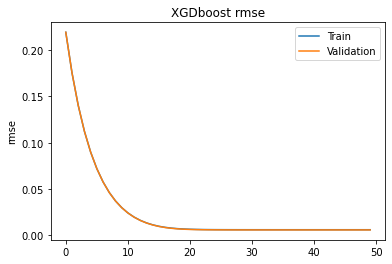

In [20]:
plot_rmse(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

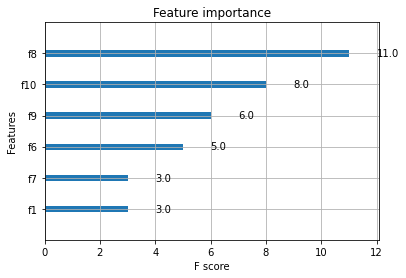

In [21]:
plot_importance(model,max_num_features=10)

In [38]:
test_df=s.groupby('security_id')[['security_id','data_date']].apply(get_test).reset_index(drop=True)

In [39]:
test_df['syn_factor']=y_pred=model.predict(X_test)
test_df['y_true']=y_test

In [40]:
# rmse for test dataset
def calculate_rmse(arr1, arr2):
    return np.sqrt(np.mean((arr1 - arr2)**2))

calculate_rmse(test_df['syn_factor'],test_df['y_true'])

0.005753219213174727

In [41]:
test_df['counts']=test_df.groupby('data_date')['data_date'].transform('count')
test_df=test_df[test_df.counts>=200]

In [42]:
test_df['factor_ma']=test_df.groupby('security_id')['syn_factor'].rolling(5).mean().reset_index(level=0, drop=True)
test_df=test_df.sort_values(by=['data_date','factor_ma']).dropna()

In [88]:
def cal_ret(x):
    n=x.shape[0]
    q=int(n*0.1)
    signals=np.concatenate([-np.ones(q), np.zeros(n-2*q), np.ones(q)])
    signals=signals.reshape(1,-1)
    return (signals @ x.values.reshape(-1,1)).item()

In [89]:
daily_ret=test_df.groupby('data_date')['y_true'].apply(cal_ret)

In [90]:
risk_free_rate = 0.017

sharpe_ratio = (daily_ret.mean() - risk_free_rate) / daily_ret.std()*np.sqrt(252)

cum_ratios = (1 + pd.Series(daily_ret)).cumprod()
cum_max = cum_ratios.cummax()
drawdown = (cum_ratios - cum_max) / cum_max
max_drawdown = drawdown.min()

winning_trades_count = sum(1 for ret in daily_ret if ret > 0)
win_rate = (winning_trades_count / daily_ret.shape[0]) 

volatility = np.std(daily_ret)

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Maximum Drawdown: {max_drawdown}")
print(f"Win Rate: {win_rate:.2f}")
print(f"Volatility: {volatility:.4f}")

Sharpe Ratio: 1.2338297125310784
Maximum Drawdown: -0.9777353904029861
Win Rate: 0.54
Volatility: 0.2392


In [91]:
cumulative_returns=cum_ratios-1

<AxesSubplot:title={'center':'cumulative returns'}, xlabel='date', ylabel='%'>

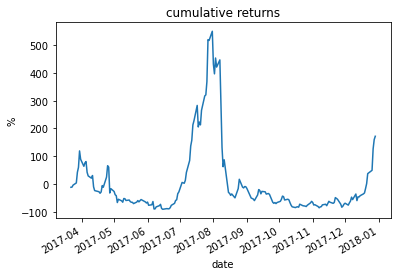

In [92]:
cum_rets_pct=cumulative_returns*100
cum_rets_pct.plot(ylabel='%',xlabel='date',title='cumulative returns')